In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict

import warnings
warnings.filterwarnings('ignore')

pd.set_option("display.max_columns", None)

# Load and Make Graph

In [2]:
drinks_df = pd.read_csv("../data/drinks.csv")
cleaning_df = pd.read_csv("../data/cleaning.csv")

In [3]:
def melt_drinks(drinks_df):
    ingredient_cols = [c for c in drinks_df.columns if c.startswith("strIngredient")]
    long_df = drinks_df.melt(id_vars=["strDrink"], value_vars=ingredient_cols,
                             var_name="ingredient_num", value_name="ingredient_raw")
    long_df = long_df.dropna(subset=["ingredient_raw"])
    long_df["ingredient_raw"] = long_df["ingredient_raw"].str.strip().str.lower()
    return long_df

In [4]:
long_df = melt_drinks(drinks_df)

In [5]:
long_df

,strDrink,ingredient_num,ingredient_raw
0,Mojito,strIngredient1,light rum
1,Old Fashioned,strIngredient1,bourbon
2,Long Island Tea,strIngredient1,vodka
3,Negroni,strIngredient1,gin
4,Whiskey Sour,strIngredient1,blended whiskey
...,...,...,...
5889,Egg Nog #4,strIngredient10,sugar
6501,Amaretto Liqueur,strIngredient11,glycerine
6502,Angelica Liqueur,strIngredient11,food coloring
6516,Egg Nog #4,strIngredient11,nutmeg


In [6]:
def exact_merge(long_df, cleaning_df):
    cleaning_df = cleaning_df.copy()
    cleaning_df["Id"] = cleaning_df["Id"].str.strip().str.lower()
    merged = long_df.merge(cleaning_df, left_on="ingredient_raw", right_on="Id", how="left")
    return merged

In [7]:
merged_df = exact_merge(long_df, cleaning_df)

In [8]:
merged_df.shape

(2512, 6)

# Network Analysis Pipeline

In [9]:
def preprocess_cocktail_data(df):
    """
    Preprocess the melted DataFrame to create data structures for network analysis using ingredient_raw.
    
    Parameters:
        df: DataFrame with columns ['strDrink', 'ingredient_num', 'ingredient_raw', 'standardized_name', 'category']
    
    Returns:
        drink_ingredients: Dict mapping drinks (lowercase) to list of raw ingredients (lowercase)
        ingredient_drinks: Dict mapping raw ingredients (lowercase) to set of drinks (lowercase)
        category_map: Dict mapping raw ingredients (lowercase) to categories
        original_names: Dict mapping lowercase names to original case for output
    """
    # Create mapping from raw ingredients to categories and preserve original case
    category_map = {}
    original_names = {}
    
    for _, row in df.iterrows():
        raw_ingredient = row['ingredient_raw']
        drink = row['strDrink']
        if pd.notna(raw_ingredient) and raw_ingredient.strip() != '':
            raw_lower = raw_ingredient.lower().strip()
            category_map[raw_lower] = row['category']
            original_names[raw_lower] = raw_ingredient
        if pd.notna(drink) and drink.strip() != '':
            original_names[drink.lower().strip()] = drink
    
    # Build drink-ingredient and ingredient-drink mappings
    drink_ingredients = defaultdict(list)
    ingredient_drinks = defaultdict(set)
    
    for _, row in df.iterrows():
        drink = row['strDrink']
        raw_ingredient = row['ingredient_raw']
        
        if pd.notna(drink) and drink.strip() != '' and pd.notna(raw_ingredient) and raw_ingredient.strip() != '':
            drink_lower = drink.lower().strip()
            raw_lower = raw_ingredient.lower().strip()
            if raw_lower not in drink_ingredients[drink_lower]:
                drink_ingredients[drink_lower].append(raw_lower)
                ingredient_drinks[raw_lower].add(drink_lower)
    
    # Convert defaultdict to regular dict
    drink_ingredients = dict(drink_ingredients)
    
    return drink_ingredients, ingredient_drinks, category_map, original_names

def build_networks(drink_ingredients):
    """
    Build bipartite and co-occurrence networks using lowercase raw ingredients.
    
    Parameters:
        drink_ingredients: Dict mapping drinks to list of raw ingredients (lowercase)
    
    Returns:
        networks: Dict containing bipartite and co-occurrence networks
    """
    networks = {}
    
    # 1. Bipartite network (drinks to raw ingredients)
    G_bipartite = nx.Graph()
    drinks = list(drink_ingredients.keys())
    all_ingredients = set()
    for ingredients in drink_ingredients.values():
        all_ingredients.update(ingredients)
    
    G_bipartite.add_nodes_from(drinks, bipartite=0, node_type='drink')
    G_bipartite.add_nodes_from(all_ingredients, bipartite=1, node_type='ingredient')
    
    for drink, ingredient_list in drink_ingredients.items():
        for ingredient in ingredient_list:
            G_bipartite.add_edge(drink, ingredient)
    
    networks['bipartite'] = G_bipartite
    
    # 2. Ingredient co-occurrence network (weighted by co-occurrence count)
    G_cooccurrence = nx.Graph()
    G_cooccurrence.add_nodes_from(all_ingredients)
    
    # Count co-occurrences
    cooccurrence_counts = defaultdict(int)
    for drink, ingredient_list in drink_ingredients.items():
        for i, ing1 in enumerate(ingredient_list):
            for ing2 in ingredient_list[i+1:]:
                pair = tuple(sorted([ing1, ing2]))
                cooccurrence_counts[pair] += 1
    
    for (ing1, ing2), count in cooccurrence_counts.items():
        G_cooccurrence.add_edge(ing1, ing2, weight=count, cooccurrence=count)
    
    networks['cooccurrence'] = G_cooccurrence
    
    return networks

def detect_ingredient_communities(G_cooccurrence, resolution=1.0):
    """
    Detect communities of raw ingredients that commonly appear together.
    
    Parameters:
        G_cooccurrence: NetworkX co-occurrence graph
        resolution: Resolution parameter for community detection
    
    Returns:
        communities: Dict mapping community ID to list of raw ingredients (lowercase)
        partition: Dict mapping raw ingredient (lowercase) to community ID
    """
    try:
        import community as community_louvain
        partition = community_louvain.best_partition(G_cooccurrence, resolution=resolution)
    except ImportError:
        print("python-louvain not installed, using alternative community detection")
        communities = nx.community.greedy_modularity_communities(G_cooccurrence, resolution=resolution)
        partition = {}
        for i, community in enumerate(communities):
            for node in community:
                partition[node] = i
    
    communities = defaultdict(list)
    for ingredient, community_id in partition.items():
        communities[community_id].append(ingredient)
    
    return dict(communities), partition

def analyze_recipe_complexity(drink_ingredients, category_map):
    """
    Analyze recipe complexity based on ingredient count and category diversity.
    
    Parameters:
        drink_ingredients: Dict mapping drinks (lowercase) to list of raw ingredients (lowercase)
        category_map: Dict mapping raw ingredients (lowercase) to categories
    
    Returns:
        complexity_df: DataFrame with complexity analysis
    """
    complexity_analysis = []
    
    for drink, ingredients in drink_ingredients.items():
        # Basic metrics
        ingredient_count = len(ingredients)
        category_count = len(set(category_map.get(ing, 'Unknown') for ing in ingredients))
        
        # Category diversity
        categories = [category_map.get(ing, 'Unknown') for ing in ingredients]
        category_diversity = len(set(categories)) / len(categories) if categories else 0
        
        # Complexity scoring
        complexity_score = (
            ingredient_count * 0.5 +
            category_count * 0.5
        )
        
        # Classify difficulty
        if complexity_score <= 2:
            difficulty = 'Beginner'
        elif complexity_score <= 4:
            difficulty = 'Intermediate'
        else:
            difficulty = 'Advanced'
        
        complexity_analysis.append({
            'drink': drink,
            'ingredient_count': ingredient_count,
            'category_count': category_count,
            'category_diversity': category_diversity,
            'complexity_score': complexity_score,
            'difficulty': difficulty,
            'categories': list(set(categories))
        })
    
    return pd.DataFrame(complexity_analysis)

def calculate_bipartite_centralities(G):
    """
    Calculate centrality measures for bipartite network.
    
    Parameters:
        G: Bipartite NetworkX graph
    
    Returns:
        centralities: Dict with centrality measures
    """
    drinks = {n for n, d in G.nodes(data=True) if d['bipartite'] == 0}
    ingredients = {n for n, d in G.nodes(data=True) if d['bipartite'] == 1}
    
    centralities = {}
    
    # Bipartite degree centrality
    centralities['degree'] = nx.bipartite.degree_centrality(G, ingredients)
    
    # Bipartite betweenness centrality
    centralities['betweenness'] = nx.bipartite.betweenness_centrality(G, ingredients)
    
    # Bipartite closeness centrality
    centralities['closeness'] = nx.bipartite.closeness_centrality(G, ingredients)
    
    # Project onto ingredient space for eigenvector centrality
    ingredient_projection = nx.bipartite.weighted_projected_graph(G, ingredients)
    
    try:
        proj_eigenvector = nx.eigenvector_centrality(ingredient_projection, max_iter=1000)
        centralities['eigenvector'] = {node: proj_eigenvector.get(node, 0.0) for node in G.nodes()}
    except:
        print("Eigenvector centrality calculation failed, using PageRank on projection instead")
        proj_pagerank = nx.pagerank(ingredient_projection)
        centralities['eigenvector'] = {node: proj_pagerank.get(node, 0.0) for node in G.nodes()}
    
    return centralities

def find_makeable_drinks(available_ingredients, drink_ingredients):
    """
    Find drinks that can be made with the available raw ingredients.
    
    Parameters:
        available_ingredients: List or set of available raw ingredient names (case-insensitive)
        drink_ingredients: Dict mapping drinks (lowercase) to list of raw ingredients (lowercase)
    
    Returns:
        List of makeable drinks (lowercase)
    """
    available = {str(ing).lower().strip() for ing in available_ingredients}
    makeable = []
    for drink, ing_list in drink_ingredients.items():
        if set(ing_list) <= available:
            makeable.append(drink)
    return makeable

def find_near_makeable_drinks(available_ingredients, drink_ingredients, makeable_drinks, max_missing=1, top_n=3):
    """
    Find top N drinks missing at most max_missing ingredients, ranked by Jaccard similarity.
    
    Parameters:
        available_ingredients: List or set of available raw ingredient names (case-insensitive)
        drink_ingredients: Dict mapping drinks (lowercase) to list of raw ingredients (lowercase)
        makeable_drinks: List of makeable drinks (lowercase) for similarity comparison
        max_missing: Maximum number of missing ingredients (default: 1)
        top_n: Number of top similar drinks to return (default: 3)
    
    Returns:
        List of dicts: {'drink': drink, 'missing': list, 'similarity': float}
    """
    available = {str(ing).lower().strip() for ing in available_ingredients}
    near_makeable = []
    
    for drink, ing_list in drink_ingredients.items():
        if drink in makeable_drinks:
            continue  # Skip makeable drinks
        missing = set(ing_list) - available
        if 0 < len(missing) <= max_missing:
            # Calculate Jaccard similarity
            drink_ingredients_set = set(ing_list)
            if makeable_drinks:
                # Compare to each makeable drink and take max similarity
                similarities = []
                for makeable in makeable_drinks:
                    makeable_ingredients = set(drink_ingredients[makeable])
                    intersection = len(drink_ingredients_set & makeable_ingredients)
                    union = len(drink_ingredients_set | makeable_ingredients)
                    similarity = intersection / union if union > 0 else 0
                    similarities.append(similarity)
                max_similarity = max(similarities) if similarities else 0
            else:
                # Compare to available ingredients
                intersection = len(drink_ingredients_set & available)
                union = len(drink_ingredients_set | available)
                max_similarity = intersection / union if union > 0 else 0
            near_makeable.append({
                'drink': drink,
                'missing': list(missing),
                'similarity': max_similarity
            })
    
    # Sort by similarity (descending) and take top N
    near_makeable.sort(key=lambda x: x['similarity'], reverse=True)
    return near_makeable[:top_n]

def find_substitutes(target_ingredient, category_map, G_cooccurrence, ingredient_drinks, n_suggestions=5):
    """
    Find substitute raw ingredients from the same category, preferring those that co-occur.
    
    Parameters:
        target_ingredient: The raw ingredient to replace (case-insensitive)
        category_map: Dict mapping raw ingredients (lowercase) to categories
        G_cooccurrence: Co-occurrence network
        ingredient_drinks: Dict mapping raw ingredients (lowercase) to set of drinks
        n_suggestions: Number of suggestions to return
    
    Returns:
        List of dicts: {'substitute': ing (lowercase), 'cooccurrence_weight': weight, 'popularity': num_drinks}
    """
    target_ing_lower = str(target_ingredient).lower().strip()
    target_cat = category_map.get(target_ing_lower)
    if not target_cat:
        return []
    
    substitutes = []
    
    # Prefer co-occurring in same category
    if target_ing_lower in G_cooccurrence:
        neighbors = G_cooccurrence.neighbors(target_ing_lower)
        for neighbor in neighbors:
            if category_map.get(neighbor) == target_cat and neighbor != target_ing_lower:
                weight = G_cooccurrence.edges[target_ing_lower, neighbor].get('weight', 0)
                popularity = len(ingredient_drinks.get(neighbor, set()))
                substitutes.append({
                    'substitute': neighbor,
                    'cooccurrence_weight': weight,
                    'popularity': popularity
                })
    
    # If few or no co-occurring, add popular ones from category
    if len(substitutes) < n_suggestions:
        all_same_cat = [
            {'substitute': ing, 'cooccurrence_weight': 0, 'popularity': len(ingredient_drinks.get(ing, set()))}
            for ing in category_map if category_map[ing] == target_cat and ing != target_ing_lower
        ]
        all_same_cat.sort(key=lambda x: x['popularity'], reverse=True)
        for sub in all_same_cat:
            if len(substitutes) >= n_suggestions:
                break
            if sub['substitute'] not in [s['substitute'] for s in substitutes]:
                substitutes.append(sub)
    
    # Sort by cooccurrence weight descending, then popularity
    substitutes.sort(key=lambda x: (-x['cooccurrence_weight'], -x['popularity']))
    
    return substitutes[:n_suggestions]

def recommend_replacements_for_near_drinks(near_makeable, category_map, G_cooccurrence, ingredient_drinks, n_suggestions=3):
    """
    For near-makeable drinks, suggest replacements for missing ingredients.
    
    Parameters:
        near_makeable: List from find_near_makeable_drinks
        category_map: Dict mapping raw ingredients (lowercase) to categories
        G_cooccurrence: Co-occurrence network
        ingredient_drinks: Dict mapping raw ingredients (lowercase) to set of drinks
        n_suggestions: Number of substitute suggestions per missing ingredient
    
    Returns:
        Enhanced near_makeable list with 'substitutes' for each missing
    """
    enhanced = []
    for item in near_makeable:
        enhanced_item = item.copy()
        enhanced_item['substitutes'] = {}
        for missing_ing in item['missing']:
            subs = find_substitutes(missing_ing, category_map, G_cooccurrence, ingredient_drinks, n_suggestions)
            enhanced_item['substitutes'][missing_ing] = subs
        enhanced.append(enhanced_item)
    return enhanced

def visualize_analysis(networks, communities, complexity_df, ingredient_stats_df, original_names, figsize=(15, 10)):
    """
    Create visualizations for bipartite and co-occurrence network analysis.
    
    Parameters:
        networks: Dict containing bipartite and co-occurrence networks
        communities: Dict mapping community ID to list of raw ingredients (lowercase)
        complexity_df: DataFrame with complexity analysis
        ingredient_stats_df: DataFrame with ingredient statistics
        original_names: Dict mapping lowercase names to original case
        figsize: Figure size tuple
    """
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)
    
    # 1. Community network visualization (top left, span 2 columns)
    ax1 = fig.add_subplot(gs[0, :2])
    G_cooccurrence = networks['cooccurrence']
    largest_cc = max(nx.connected_components(G_cooccurrence), key=len)
    G_viz = G_cooccurrence.subgraph(largest_cc)
    
    pos = nx.spring_layout(G_viz, k=1, iterations=50)
    node_colors = []
    community_partition = {}
    for comm_id, members in communities.items():
        for member in members:
            community_partition[member] = comm_id
    
    colors = plt.cm.Set3(np.linspace(0, 1, len(communities)))
    for node in G_viz.nodes():
        comm_id = community_partition.get(node, 0)
        node_colors.append(colors[comm_id % len(colors)])
    
    nx.draw(G_viz, pos, ax=ax1, node_color=node_colors, node_size=50, 
            edge_color='lightgray', alpha=0.7, with_labels=False)
    ax1.set_title('Ingredient Co-occurrence Communities')
    
    # 2. Complexity distribution (top right)
    ax2 = fig.add_subplot(gs[0, 2])
    difficulty_counts = complexity_df['difficulty'].value_counts()
    ax2.pie(difficulty_counts.values, labels=difficulty_counts.index, autopct='%1.1f%%')
    ax2.set_title('Recipe Complexity Distribution')
    
    # 3. Community sizes (bottom left)
    ax3 = fig.add_subplot(gs[1, 0])
    community_sizes = [len(members) for members in communities.values()]
    ax3.hist(community_sizes, bins=10, alpha=0.7, color='skyblue', edgecolor='black')
    ax3.set_xlabel('Community Size')
    ax3.set_ylabel('Number of Communities')
    ax3.set_title('Community Size Distribution')
    
    # 4. Ingredient count vs complexity (bottom center)
    ax4 = fig.add_subplot(gs[1, 1])
    scatter = ax4.scatter(complexity_df['ingredient_count'], complexity_df['complexity_score'], 
                         c=[{'Beginner': 0, 'Intermediate': 1, 'Advanced': 2}[d] 
                           for d in complexity_df['difficulty']], 
                         cmap='viridis', alpha=0.6)
    ax4.set_xlabel('Number of Ingredients')
    ax4.set_ylabel('Complexity Score')
    ax4.set_title('Ingredients vs Complexity')
    plt.colorbar(scatter, ax=ax4)
    
    # 5. Top categories by centrality (bottom right)
    ax5 = fig.add_subplot(gs[1, 2])
    category_centrality = ingredient_stats_df.groupby('category')['degree_centrality'].mean().sort_values(ascending=False)[:8]
    ax5.barh(range(len(category_centrality)), category_centrality.values)
    ax5.set_yticks(range(len(category_centrality)))
    ax5.set_yticklabels(category_centrality.index)
    ax5.set_xlabel('Average Degree Centrality')
    ax5.set_title('Category Importance')
    
    plt.suptitle('Cocktail Network Analysis Dashboard', fontsize=16, y=0.98)
    plt.tight_layout()
    plt.show()
    
def export_gephi_files(G_bipartite, G_cooccurrence, original_names, output_dir='../data'):
    """
    Export bipartite and co-occurrence networks to Gephi-ready CSV files.
    
    Parameters:
        G_bipartite: NetworkX bipartite graph (drinks and ingredients)
        G_cooccurrence: NetworkX graph (ingredient co-occurrence)
        original_names: Dict mapping lowercase names to original case
        output_dir: Directory to save CSV files
    """
    import os
    os.makedirs(output_dir, exist_ok=True)
    
    # Bipartite Nodes CSV
    nodes_data = []
    for node, data in G_bipartite.nodes(data=True):
        nodes_data.append({
            'Id': node,
            'Label': original_names.get(node, node),
            'Type': data['node_type'].capitalize()
        })
    nodes_df = pd.DataFrame(nodes_data)
    nodes_df.to_csv(f'{output_dir}/nodes.csv', index=False)
    print(f"   • Saved nodes.csv with {len(nodes_df)} nodes to {output_dir}")
    
    # Bipartite Edges CSV
    edges_data = []
    for source, target in G_bipartite.edges():
        edges_data.append({
            'Source': source,
            'Target': target,
            'Type': 'Undirected'
        })
    edges_df = pd.DataFrame(edges_data)
    edges_df.to_csv(f'{output_dir}/edges.csv', index=False)
    print(f"   • Saved edges.csv with {len(edges_df)} edges to {output_dir}")
    
    # Co-occurrence Nodes CSV
    co_nodes_data = []
    for node in G_cooccurrence.nodes():
        co_nodes_data.append({
            'Id': node,
            'Label': original_names.get(node, node),
            'Type': 'Ingredient'
        })
    co_nodes_df = pd.DataFrame(co_nodes_data)
    co_nodes_df.to_csv(f'{output_dir}/nodes_cooccurrence.csv', index=False)
    print(f"   • Saved nodes_cooccurrence.csv with {len(co_nodes_df)} nodes to {output_dir}")
    
    # Co-occurrence Edges CSV
    co_edges_data = []
    for source, target, data in G_cooccurrence.edges(data=True):
        co_edges_data.append({
            'Source': source,
            'Target': target,
            'Type': 'Undirected',
            'Weight': data.get('weight', 1)
        })
    co_edges_df = pd.DataFrame(co_edges_data)
    co_edges_df.to_csv(f'{output_dir}/edges_cooccurrence.csv', index=False)
    print(f"   • Saved edges_cooccurrence.csv with {len(co_edges_df)} edges to {output_dir}")

def comprehensive_analysis_pipeline(df):
    """
    Complete analysis pipeline for bipartite and co-occurrence networks with detailed results.
    
    Parameters:
        df: Melted DataFrame with columns ['strDrink', 'ingredient_num', 'ingredient_raw', 'standardized_name', 'category']
    
    Returns:
        results: Dict containing all analysis results
    """
    print("Starting Cocktail Network Analysis...")
    
    # Step 1: Data preprocessing
    print("Processing data...")
    drink_ingredients, ingredient_drinks, category_map, original_names = preprocess_cocktail_data(df)
    print(f"   • Processed {len(drink_ingredients)} drinks with {len(ingredient_drinks)} unique ingredients")
    
    # Step 2: Build networks
    print("\n\nBuilding network representations...")
    networks = build_networks(drink_ingredients)
    print(f"   • Bipartite network: {networks['bipartite'].number_of_nodes()} nodes, {networks['bipartite'].number_of_edges()} edges")
    print(f"   • Co-occurrence network: {networks['cooccurrence'].number_of_nodes()} nodes, {networks['cooccurrence'].number_of_edges()} edges")
    
    # Network statistics
    G_co = networks['cooccurrence']
    avg_degree = sum(dict(G_co.degree()).values()) / G_co.number_of_nodes()
    density = nx.density(G_co)
    print("   • Network Statistics:")
    print(f"     - Average Degree: {avg_degree:.2f}")
    print(f"     - Density: {density:.4f}")
    
    print("\n\n   • Exporting bipartite network for Gephi...")
    export_gephi_files(networks['bipartite'], networks['cooccurrence'], original_names)
    
    # Step 3: Community detection
    print("\n\nDetecting ingredient communities...")
    communities, communities_partition = detect_ingredient_communities(networks['cooccurrence'])
    print(f"   • Found {len(communities)} communities")
    print("   • Largest communities:")
    sorted_communities = sorted(communities.items(), key=lambda x: len(x[1]), reverse=True)
    for i, (comm_id, members) in enumerate(sorted_communities[:3]):
        member_names = [original_names.get(m, m) for m in members[:5]]
        print(f"     - Community {comm_id}: {len(members)} ingredients ({', '.join(member_names)}{'...' if len(members) > 5 else ''})")
    
    # Step 4: Calculate centralities
    print("\n\nCalculating bipartite centralities...")
    centralities = calculate_bipartite_centralities(networks['bipartite'])
    
    # Ingredient statistics with centralities
    ingredients = {n for n, d in networks['bipartite'].nodes(data=True) if d['bipartite'] == 1}
    ingredient_stats = []
    for ingredient in ingredients:
        stats = {
            'ingredient': original_names.get(ingredient, ingredient),
            'ingredient_lower': ingredient,
            'drinks_count': len(ingredient_drinks[ingredient]),
            'category': category_map.get(ingredient, 'Unknown'),
            'degree_centrality': centralities['degree'].get(ingredient, 0),
            'betweenness_centrality': centralities['betweenness'].get(ingredient, 0),
            'closeness_centrality': centralities['closeness'].get(ingredient, 0),
            'eigenvector_centrality': centralities['eigenvector'].get(ingredient, 0),
            'community': communities_partition.get(ingredient, -1)
        }
        ingredient_stats.append(stats)
    
    ingredient_stats_df = pd.DataFrame(ingredient_stats).sort_values('drinks_count', ascending=False)
    
    # Print top 5 ingredients by centrality
    print("   • Top 5 Ingredients by Centrality:")
    print("     - By Degree Centrality:")
    for _, row in ingredient_stats_df.sort_values('degree_centrality', ascending=False).head(5).iterrows():
        print(f"       • {row['ingredient']}: {row['degree_centrality']:.3f} (Used in {row['drinks_count']} drinks)")
    print("     - By Betweenness Centrality:")
    for _, row in ingredient_stats_df.sort_values('betweenness_centrality', ascending=False).head(5).iterrows():
        print(f"       • {row['ingredient']}: {row['betweenness_centrality']:.3f}")
    print("     - By Eigenvector Centrality:")
    for _, row in ingredient_stats_df.sort_values('eigenvector_centrality', ascending=False).head(5).iterrows():
        print(f"       • {row['ingredient']}: {row['eigenvector_centrality']:.3f}")
    
    # Step 5: Recipe complexity analysis
    print("\n\nAnalyzing recipe complexity...")
    complexity_df = analyze_recipe_complexity(drink_ingredients, category_map)
    complexity_df['drink'] = complexity_df['drink'].apply(lambda x: original_names.get(x, x))
    
    complexity_summary = complexity_df['difficulty'].value_counts()
    print(f"   • Recipe difficulty distribution: {dict(complexity_summary)}")
    print("   • Top 5 Most Complex Drinks:")
    for _, row in complexity_df.sort_values('complexity_score', ascending=False).head(5).iterrows():
        ingredients = [original_names.get(ing, ing) for ing in drink_ingredients[row['drink'].lower()]]
        print(f"     - {row['drink']}: Score {row['complexity_score']:.2f}, Difficulty: {row['difficulty']}, Ingredients: {', '.join(ingredients)}")
    
    # Step 6: Compile results
    results = {
        'data': {
            'drink_ingredients': drink_ingredients,
            'ingredient_drinks': ingredient_drinks,
            'category_map': category_map,
            'original_names': original_names
        },
        'networks': networks,
        'communities': {
            'communities': communities,
            'partition': communities_partition
        },
        'centralities': centralities,
        'analysis': {
            'ingredient_stats': ingredient_stats_df,
            'complexity': complexity_df
        }
    }
    
    print("\n\nAnalysis complete!")
    print("Use the following functions for recommendations:")
    print("   • find_makeable_drinks() - Drinks you can make exactly")
    print("   • find_near_makeable_drinks() - Top 3 drinks missing few ingredients, ranked by similarity")
    print("   • find_substitutes() - Ingredient replacements from same category")
    print("   • recommend_replacements_for_near_drinks() - Combined near-drinks with substitutes")
    print("   • visualize_analysis() - Visualizations")
    
    return results

In [10]:
results = comprehensive_analysis_pipeline(merged_df)

Starting Cocktail Network Analysis...
Processing data...
   • Processed 627 drinks with 345 unique ingredients


Building network representations...
   • Bipartite network: 966 nodes, 2493 edges
   • Co-occurrence network: 345 nodes, 2646 edges
   • Network Statistics:
     - Average Degree: 15.34
     - Density: 0.0446


   • Exporting bipartite network for Gephi...
   • Saved nodes.csv with 966 nodes to ../data
   • Saved edges.csv with 2493 edges to ../data
   • Saved nodes_cooccurrence.csv with 345 nodes to ../data
   • Saved edges_cooccurrence.csv with 2646 edges to ../data


Detecting ingredient communities...
   • Found 8 communities
   • Largest communities:
     - Community 0: 102 ingredients (cointreau, dark rum, beer, mezcal, malibu rum...)
     - Community 4: 68 ingredients (grain alcohol, sugar, cinnamon, chocolate ice-cream, banana...)
     - Community 3: 65 ingredients (dubonnet rouge, figs, scotch, kummel, rye whiskey...)


Calculating bipartite centralities...
   • Top

# Drink Recommender

In [11]:
def recommend_drinks(my_ingredients):
    makeable = find_makeable_drinks(my_ingredients, results['data']['drink_ingredients'])
    near = find_near_makeable_drinks(my_ingredients, results['data']['drink_ingredients'], makeable, max_missing=1, top_n=3)
    recommendations = recommend_replacements_for_near_drinks(
        near, results['data']['category_map'], results['networks']['cooccurrence'],
        results['data']['ingredient_drinks'], n_suggestions=3
    )

    print("\nDrinks You Can Make:")
    if makeable:
        for drink in makeable:
            drink_name = results['data']['original_names'].get(drink, drink)
            ingredients = [results['data']['original_names'].get(ing, ing) for ing in results['data']['drink_ingredients'][drink]]
            print(f"  - {drink_name}:")
            print(f"    Ingredients: {', '.join(ingredients)}")
    else:
        print("  No drinks can be made with the available ingredients.")
    print("\nDrinks Almost Makeable (Top 3 by Similarity, Missing 1 Ingredient):")
    if near:
        for item in near:
            drink = results['data']['original_names'].get(item['drink'], item['drink'])
            missing = [results['data']['original_names'].get(m, m) for m in item['missing']]
            ingredients = [results['data']['original_names'].get(ing, ing) for ing in results['data']['drink_ingredients'][item['drink']]]
            print(f"  - {drink}:")
            print(f"    Ingredients: {', '.join(ingredients)}")
            print(f"    Missing: {missing[0]} (Similarity: {item['similarity']:.2f})")
    else:
        print("  No drinks are missing only one ingredient.")
    print("\nRecommendations with Substitutes:")
    if recommendations:
        print("  (Top 3 substitutes per missing ingredient, sorted by co-occurrence and popularity)")
        for item in recommendations:
            drink = results['data']['original_names'].get(item['drink'], item['drink'])
            missing = [results['data']['original_names'].get(m, m) for m in item['missing']]
            ingredients = [results['data']['original_names'].get(ing, ing) for ing in results['data']['drink_ingredients'][item['drink']]]
            print(f"  - {drink}:")
            print(f"    Ingredients: {', '.join(ingredients)}")
            for m in missing:
                print(f"    Missing: {m}")
                subs = item['substitutes'].get(m.lower(), [])
                if subs:
                    print("    Suggested Substitutes:")
                    for s in subs:
                        sub_name = results['data']['original_names'].get(s['substitute'], s['substitute'])
                        print(f"      • {sub_name} (Co-occurrence: {s['cooccurrence_weight']}, Popularity: {s['popularity']})")
                else:
                    print("      No substitutes found in the same category.")
    else:
        print("  No recommendations available.")


In [12]:
my_ingredients = ['Rum', 'Lime Juice', 'Gin', '7-up']
recommend_drinks(my_ingredients)


Drinks You Can Make:
  No drinks can be made with the available ingredients.

Drinks Almost Makeable (Top 3 by Similarity, Missing 1 Ingredient):
  - Imperial Cocktail:
    Ingredients: lime juice, gin, aperol
    Missing: aperol (Similarity: 0.40)
  - 69 Special:
    Ingredients: gin, 7-up, lemon juice
    Missing: lemon juice (Similarity: 0.40)
  - Flying Dutchman:
    Ingredients: gin, triple sec
    Missing: triple sec (Similarity: 0.20)

Recommendations with Substitutes:
  (Top 3 substitutes per missing ingredient, sorted by co-occurrence and popularity)
  - Imperial Cocktail:
    Ingredients: lime juice, gin, aperol
    Missing: aperol
    Suggested Substitutes:
      • triple sec (Co-occurrence: 0, Popularity: 40)
      • amaretto (Co-occurrence: 0, Popularity: 40)
      • kahlua (Co-occurrence: 0, Popularity: 28)
  - 69 Special:
    Ingredients: gin, 7-up, lemon juice
    Missing: lemon juice
    Suggested Substitutes:
      • orange juice (Co-occurrence: 6, Popularity: 72)
  

In [13]:
my_ingredients = ['Rum', 'Blue Curacao', 'Pineapple Juice', 'Vodka', 'Orange Juice']
recommend_drinks(my_ingredients)


Drinks You Can Make:
  - Screwdriver:
    Ingredients: vodka, orange juice

Drinks Almost Makeable (Top 3 by Similarity, Missing 1 Ingredient):
  - Harvey Wallbanger:
    Ingredients: vodka, galliano, orange juice
    Missing: galliano (Similarity: 0.67)
  - Addison Special:
    Ingredients: vodka, grenadine, orange juice
    Missing: grenadine (Similarity: 0.67)
  - After sex:
    Ingredients: vodka, creme de banane, orange juice
    Missing: creme de banane (Similarity: 0.67)

Recommendations with Substitutes:
  (Top 3 substitutes per missing ingredient, sorted by co-occurrence and popularity)
  - Harvey Wallbanger:
    Ingredients: vodka, galliano, orange juice
    Missing: galliano
    Suggested Substitutes:
      • triple sec (Co-occurrence: 2, Popularity: 40)
      • kahlua (Co-occurrence: 1, Popularity: 28)
      • amaretto (Co-occurrence: 0, Popularity: 40)
  - Addison Special:
    Ingredients: vodka, grenadine, orange juice
    Missing: grenadine
    Suggested Substitutes:
  

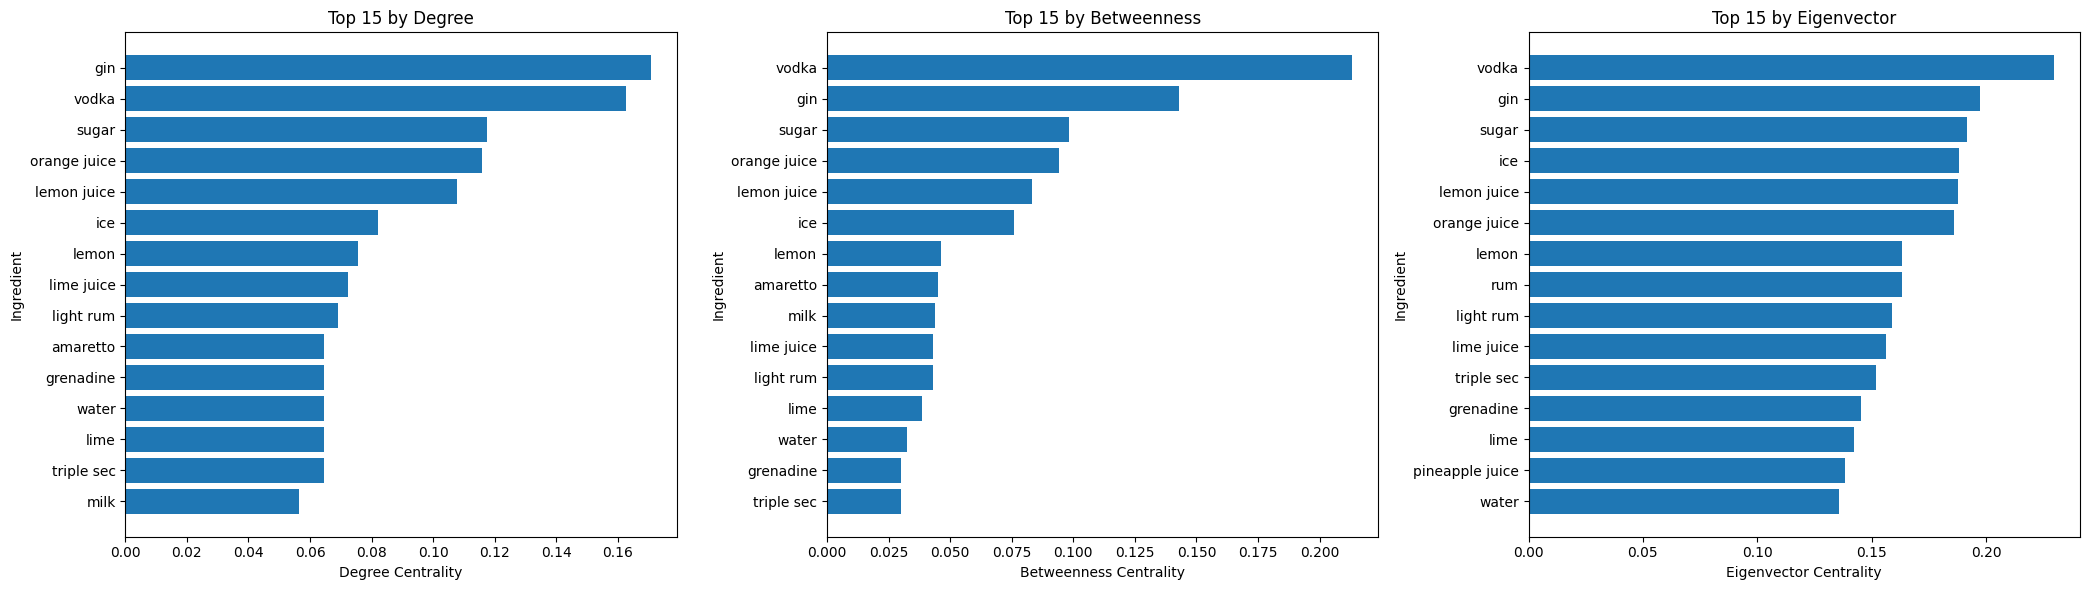

In [14]:
def plot_top10_centralities_1x3_from_results(results):
    df = results['analysis']['ingredient_stats'].copy()
    fig, axes = plt.subplots(1, 3, figsize=(21, 6), sharey=False)

    specs = [
        ('degree_centrality', 'Top 15 by Degree', 'Degree Centrality'),
        ('betweenness_centrality', 'Top 15 by Betweenness', 'Betweenness Centrality'),
        ('eigenvector_centrality', 'Top 15 by Eigenvector', 'Eigenvector Centrality'),
    ]

    for ax, (col, title, xlabel) in zip(axes, specs):
        top = df.sort_values(col, ascending=False).head(15)[['ingredient', col]].iloc[::-1]
        ax.barh(top['ingredient'], top[col])
        ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel("Ingredient")

    plt.tight_layout()
    plt.show()

plot_top10_centralities_1x3_from_results(results)